<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Feature Engineering</a></span><ul class="toc-item"><li><span><a href="#Fire-Zone" data-toc-modified-id="Fire-Zone-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Fire Zone</a></span></li><li><span><a href="#Data-Split" data-toc-modified-id="Data-Split-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Data Split</a></span></li></ul></li><li><span><a href="#Training-with-Lag" data-toc-modified-id="Training-with-Lag-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Training with Lag</a></span></li></ul></div>

In [2]:
#  Load the "autoreload" extension so that code can change
%load_ext autoreload
%reload_ext autoreload
from pathlib import Path

#  always reload modules so that as you change code in src, it gets loaded
%autoreload 2
%matplotlib inline

import sys
sys.path.append('../')
from src.imports import *
from src.gen_functions import *
from src.features.dataset import Dataset
from src.models.train_model import train_city_s0
from src.models.predict_model import load_model
from src.visualization.vis_model import plot_model_perf
 
output_notebook()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading BokehJS ...

The dataset object has a bunch of useful functions for feature engineering. After initialize the dataset object and load the raw data. I specified `'PM2.5'` as dataset.pollutant attribute. Then called `dataset.feature_no_fire()` to merge the pollution data and the weather data. 

For the Dataset object's documentation, please refer to https://github.com/worasom/aqi_thailand2/blob/master/docs/_build/html/src.features.html.

In [3]:
# init a Dataset object for Chiang Mai
dataset = Dataset('Chiang Mai')
# load raw data 
dataset.load_()
# specified the pollution to study 
dataset.pollutant = 'PM2.5'
# merge pollution data to weather data 
dataset.feature_no_fire()

data no fire has shape (78565, 14)


For the fire data, the feature engineering step is complicated because I have to count the numbers of hotspots at various distance from the city. I then account for the amount of time the pollution generated at a particular spot would take to arrive at the city. This travel time has to be optimized during the training. Here, I use a default value to merge the fire data. 

In [4]:
# use merge fire feature using default feature setting
fire_cols, zone_list = dataset.merge_fire()

use default fire feature


After merging everything, the Dataset.data attribute contains the dataframe, which is ready training.

In [20]:
dataset.data.head(2)

,PM2.5,Temperature(C),Humidity(%),Wind Speed(kmph),wind_CALM,wind_E,wind_N,wind_S,wind_W,is_rain,is_holiday,is_weekend,day_of_week,time_of_day,fire_0_100,fire_100_200,fire_200_400,fire_400_700,fire_700_1000
datetime,,,,,,,,,,,,,,,,,,,
2011-05-17 16:00:00,1.0,27.0,74.0,10.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,16.0,-6.543377e-15,2.779997e-14,0.462279,0.085466,0.020928
2011-05-17 17:00:00,1.0,25.0,83.0,10.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,17.0,-6.543377e-15,2.779997e-14,0.462279,0.084935,0.021800


# Feature Engineering 

## Fire Zone

Since the concentration of hotspots differs at various distances from Chiang Mai, it is important to divide the burning activity into distance-based zones. The figure below shows four fire zone. The first zone is within 100 km from Chiang Mai within the Thailand border. The second and third zone is 100 - 200 km and 200 - 400 km from Chiang Mai. A lot of fire activities in this zone are in Myanmar and Laos(red spots). The third zone is between 400 and 700 km from Chiang Mai. Most burning activities here are in Laos. The last zone is between 700 and 1000 km. This zone also not only includes the burning activities in Myanmar, Laos, and Vietnam but also those in Cambodia. However, most fire activities in Cambodia, which is much further away and the burning activities concentrate in December(blue spots), which is not the month with the highest pollution in Chiang Mai. 

Note that only the hotspots within 1000 km from the coordinate of Chiang Mai (Latitude = 18.7904, Longitude=98.9847) in Mercator coordinate (https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_ system) is considered. 

In [23]:
# data to plot in excel
plot_data_list = []
city_x = merc_x(dataset.city_info['Longitude'])
city_y = merc_y(dataset.city_info['Latitude'])

stepx = 800E3
stepy = stepx

fire = dataset.fire

# range bounds supplied in web mercator coordinates
p = figure(x_range=(city_x-0.9*stepx,city_x+1.1*stepx), y_range=(city_y-stepy*0.5, city_y+stepy*0.0001),
           x_axis_type="mercator", y_axis_type="mercator",
          title = 'Fire Zone')

p.add_tile(get_provider(Vendors.STAMEN_TERRAIN_RETINA))


p.circle(city_x, city_y,color='black',line_color='black',size=5, legend_label='Chiang Mai')

i = 0
month_list = ['2019-03','2019-04']
month = month_list[i]
print(month)
color = 'red'
data = fire.loc[month:month_list[i+1]]
p.scatter(data['long_km']*1000,data['lat_km']*1000,color='red',size=1, alpha=0.5,legend_label='fire in Mar 2019')
plot_data_list.append(data)


month_list = ['2018-12','2019-01']
month = month_list[i]
print(month)
data = fire.loc[month:month_list[i+1]]
p.scatter(data['long_km']*1000,data['lat_km']*1000,color='blue',size=1, alpha=0.5, legend_label='fire in Dec 2018')
plot_data_list.append(data)


labels = ['0-100km','100-200km', '200-400km','400-700km','700-1000km']
labels.reverse()
rs = [100, 200, 400 , 700 , 1000]
rs.reverse()
colors = get_color(color_length=len(labels),cmap=cm.jet)

for i, (r, label, color) in enumerate(zip(rs, labels, colors)):
    alpha=0.2
        
    xy = get_circle(city_x, city_y,r=r*1E3)
    plot_data_list.append(pd.DataFrame(xy.transpose(),columns=['x','y']))
    p.patch(xy[0,:],xy[1,:],alpha=alpha,line_width=2,color=color, legend_label=label)
    p.line(xy[0,:],xy[1,:],alpha=alpha,line_width=3,line_color=color)
    
show(p)
export_png(p, filename=dataset.report_folder + "fire_zone.png")

2019-03
2018-12


## Data Split

model_meta.json file specified the spliting radio at different stages of training. The figure below show the spliting at the begining.

In [13]:
# Load model meta file using load_meta() function
model_meta = load_meta(dataset.model_folder + 'model_meta.json')
# meta file for modeling PM2.5
model_meta['PM2.5']['split_lists']

[[0.4, 0.3, 0.3], [0.45, 0.25, 0.3], [0.7, 0.3]]

At the beginning the data is split into train, validation and test sets. The training and validation datasets are used to optimized model hyperparameters. 

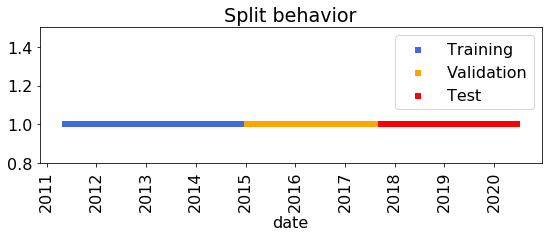

In [5]:
# visualize the split 
dataset.split_data(split_ratio=[0.4, 0.3, 0.3])
display_time_split(dataset.split_list)

After optimization, the training and validation sets are merged. The model is retrained. The test data is untouched and will be used for statistical prediction.

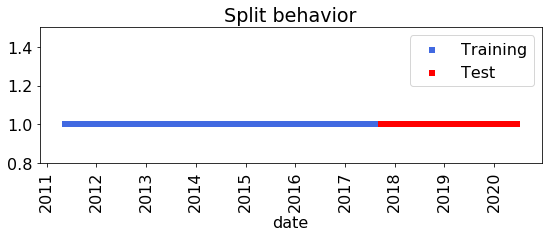

In [17]:
# visualize the split 
dataset.split_data(split_ratio=[0.7, 0.3])
display_time_split(dataset.split_list)

# Training with Lag 

Model Optimization breakdown into the following steps

1. `train_model.do_rf_search()` finds a reasonable parameters RandomForestRegressor model. Build a model input data using default fire parameters. Split the data into train, validation, and test set. Using the training and validation sets. 
2. `train_model.reduce_cols()` removes lower importance features from the model input. This is done by try to drop the data and see if the error decrease. 
3. `train_model.sk_op_fire()` optimizes for the best fire features. Assuming that the pollution from a hotspot travels to the city at a certain average speed and linger in the environment for an unknown duration. This optimization step finds out the average travel speed and average linger duration.  
4. `train_model.op_lag()` improves model performance by adding lag columns (of weather and fire). The effects of weather and hotspots can have a time lag effect. This step search for the amount of lagged to add to the model. 
5. Call `train_model.reduce_cols()` again to remove lower importance lag columns. The earlier step often adds too many lagged columns. I prune these columns here. 
6. Merge training and validation set and optimize for RandomForestRegressor parameters again.  
7. Save model and model meta information. The Model meta would contain fire feature parameters, the lagged values, and columns to use.

The entire optimization steps are carried out in a single function `train_city_s1`. This functions call a bunch of functions in train_model.py. Many of those functions are optimization using 
scikit-optimize library.  

Note that I did experiments with other machine learning model and neural network. I still find that the RandomForestRegressor has the best performance.

data no fire has shape (77747, 14)
use default fire feature
=================optimize 1: find the best RF model=================
{'n_estimators': 180, 'min_samples_split': 10, 'min_samples_leaf': 17, 'max_features': 'log2', 'max_depth': None, 'bootstrap': True} 0.07241942841927984
optimize 1 score {'val_r2_score': 0.5981000217534046, 'val_mean_squared_error': 372.4872235077907, 'val_mean_absolute_error': 10.92833695886337}
=================optimize 2: remove unncessary columns=================
old cols length 18
use columns ['Temperature(C)', 'Humidity(%)', 'Wind Speed(kmph)', 'wind_CALM', 'wind_E', 'wind_N', 'wind_S', 'wind_W', 'is_rain', 'is_holiday', 'is_weekend', 'day_of_week', 'time_of_day', 'fire_0_100', 'fire_100_200', 'fire_200_400', 'fire_400_700', 'fire_700_1000']
score after dropping columns {'r2_score': 0.5981000217534046, 'mean_squared_error': 372.4872235077907, 'mean_absolute_error': 10.92833695886337}
================= optimization 3: find the best fire feature =========

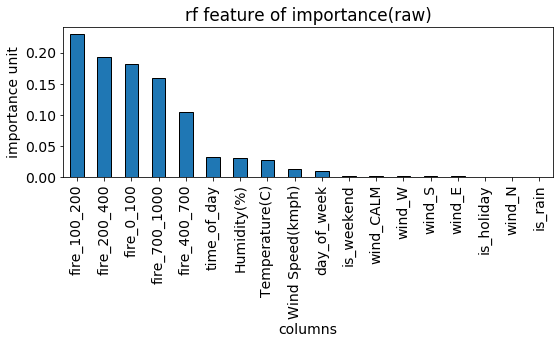

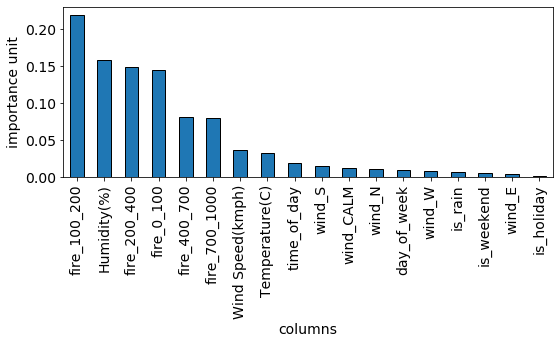

In [10]:
%%time 
# with out roll 
data, rf_model, poll_meta = train_city_s0(city='Chiang Mai', pollutant='PM2.5', build=False)

Visualize the model performance using `vis_model.plot_model_perf()` command

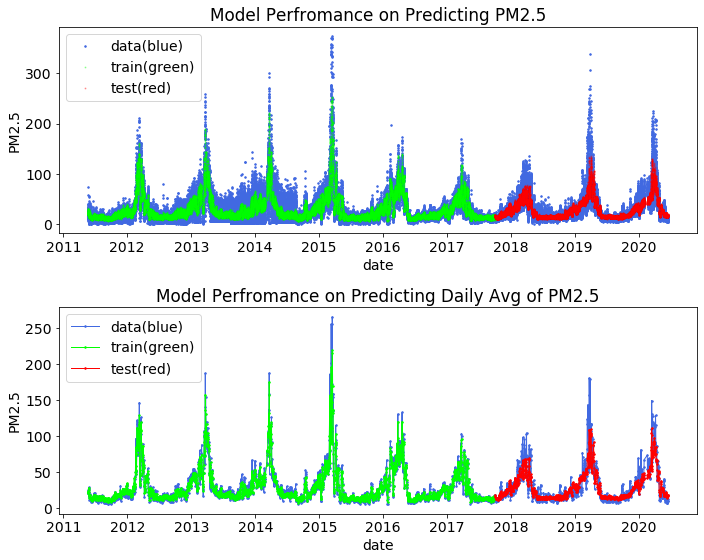

In [13]:
_, df = plot_model_perf(dataset=data, model=rf_model, split_list=[0.7, 0.3], xlim=[], to_save=False)

To load the model. Use `predict_model.load_model()`. It would also print the R2 score and mean_squared_error. 

In [26]:
dataset, model, fire_cols, zone_list, feat_imp, rolling_win = load_model(city='Chiang Mai', pollutant='PM2.5',split_list=[0.7, 0.3])

data no fire has shape (77747, 14)
raw model performance {'test_r2_score': 0.6971263012454727, 'test_mean_squared_error': 236.87171030783028, 'test_mean_absolute_error': 9.356311166795104}
daily avg training error {'avg_trn_r2_score': 0.9750555507848502, 'avg_trn_mean_squared_error': 16.30387143688307, 'avg_trn_mean_absolute_error': 2.4689413599174954}
daily avg test error {'avg_test_r2_score': 0.7774020193313866, 'avg_test_mean_squared_error': 149.34608153552455, 'avg_test_mean_absolute_error': 7.808431861215025}
